In [14]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
# from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
# show more columns with trian_df.describe()
pd.set_option('display.max_columns', 50)
# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')
import time
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# plt.plot([-1,2,-5,3])
# plt.title(u'中文',fontproperties=myfont)
# plt.show()

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [16]:
# load data
data_dir = '../dataset/DataFountain2019-消费者人群画像/'
train_df = pd.read_csv(data_dir + 'train_dataset.csv')
test_df = pd.read_csv(data_dir + 'test_dataset.csv')

## #1 EDA

In [17]:
categorical_cols = ['是否4G不健康客户', '是否黑名单客户', '用户话费敏感度', '缴费用户当前是否欠费缴费', '是否经常逛商场的人',
                   '当月是否看电影', '当月是否景点游览', '当月是否体育场馆消费', '当月是否到过福州山姆会员店', '用户实名制是否通过核实', 
                    '当月是否逛过福州仓山万达', '是否大学生客户']
numerical_cols = ['用户年龄', '用户网龄（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
                 '用户账单当月总费用（元）', '用户当月账户余额（元）', '当月通话交往圈人数', '近三个月月均商场出现次数',
                 '当月网购类应用使用次数', '当月物流快递类应用使用次数', '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', 
                  '当月飞机类应用使用次数', '当月火车类应用使用次数', '当月旅游资讯类应用使用次数', '用户最近一次缴费距今时长（月）']
scale_cols = []
onehot_cols = categorical_cols

drop_cols = ['用户编码', '是否黑名单客户']
target = ['信用分']
print len(categorical_cols), len(numerical_cols)
print len(categorical_cols)+len(numerical_cols)+len(drop_cols)+len(target)

12 16
31


### 1.1 数据基本情况（缺失值、个字段数据类型、数值型字段的统计分布）

In [27]:
# 查看总体的情况，找出一些数据猫腻
train_df.info()
# 没有缺失值，编码是个object，大部分为整型，设计金额的为浮点型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
用户编码               50000 non-null object
用户实名制是否通过核实        50000 non-null int64
用户年龄               50000 non-null int64
是否大学生客户            50000 non-null int64
是否黑名单客户            50000 non-null int64
是否4G不健康客户          50000 non-null int64
用户网龄（月）            50000 non-null int64
用户最近一次缴费距今时长（月）    50000 non-null int64
缴费用户最近一次缴费金额（元）    50000 non-null float64
用户近6个月平均消费值（元）     50000 non-null float64
用户账单当月总费用（元）       50000 non-null float64
用户当月账户余额（元）        50000 non-null int64
缴费用户当前是否欠费缴费       50000 non-null int64
用户话费敏感度            50000 non-null int64
当月通话交往圈人数          50000 non-null int64
是否经常逛商场的人          50000 non-null int64
近三个月月均商场出现次数       50000 non-null int64
当月是否逛过福州仓山万达       50000 non-null int64
当月是否到过福州山姆会员店      50000 non-null int64
当月是否看电影            50000 non-null int64
当月是否景点游览           50000 non-null int64
当月是否体育场馆消费         50000 non-null int64
当月网购

In [13]:
train_df.describe()
# 1. ‘用户年龄’：有0岁的，也有100多岁的
# 2. ‘用户话费敏感度’：跟描述不符，出现了0

,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,用户账单当月总费用（元）,用户当月账户余额（元）,缴费用户当前是否欠费缴费,用户话费敏感度,当月通话交往圈人数,是否经常逛商场的人,近三个月月均商场出现次数,当月是否逛过福州仓山万达,当月是否到过福州山姆会员店,当月是否看电影,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.99022,37.883440,0.003720,0.048800,0.088580,96.448680,0.700100,53.415929,98.732081,99.575130,114.172400,0.052540,3.351920,48.054500,0.329500,26.572520,0.038700,0.027120,0.242280,0.47442,0.37412,1148.815260,1.197840,971.50308,3.366519e+03,0.704420,0.553340,19.117120,618.053060
std,0.09841,11.613239,0.060879,0.215452,0.284139,59.176593,0.458218,61.812022,60.757758,65.327335,304.063961,0.223116,1.241202,54.208524,0.470036,32.789251,0.192881,0.162435,0.428467,0.49935,0.48390,3992.957952,44.469584,3006.16776,1.151006e+04,28.721302,7.735913,170.074772,42.443022
min,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,422.000000
25%,1.00000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.180000,52.675000,40.000000,0.000000,2.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,18.000000,0.000000,6.00000,1.000000e+01,0.000000,0.000000,0.000000,594.000000
50%,1.00000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,89.320000,89.620000,70.000000,0.000000,4.000000,32.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.00000,0.00000,250.000000,0.000000,267.00000,3.350000e+02,0.000000,0.000000,0.000000,627.000000
75%,1.00000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,131.160000,133.945000,130.000000,0.000000,4.000000,61.000000,1.000000,50.000000,0.000000,0.000000,0.000000,1.00000,1.00000,932.000000,0.000000,1147.25000,2.423250e+03,0.000000,0.000000,4.000000,649.000000
max,1.00000,111.000000,1.000000,1.000000,1.000000,288.000000,1.000000,998.000000,840.570000,1164.290000,49040.000000,1.000000,5.000000,1906.000000,1.000000,92.000000,1.000000,1.000000,1.000000,1.00000,1.00000,234336.000000,8235.000000,496238.00000,1.382227e+06,5856.000000,474.000000,13965.000000,719.000000


### 1.2 观察变量的密度曲线（找寻浮点型特征规律）

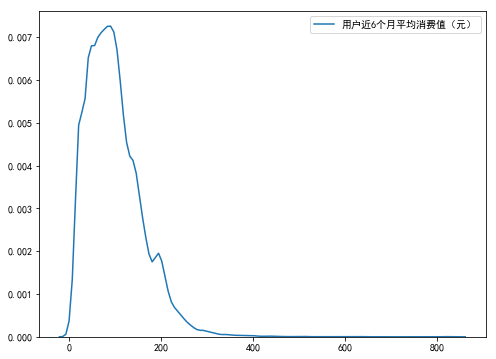

In [30]:
# 将认为有问题的可以看下密度曲线
plt.figure(figsize=(8, 6))
# train_df['用户近6个月平均消费值（元）'].plot(kind='kde')
sns.kdeplot(train_df['用户近6个月平均消费值（元）'])

### 1.3 类别特征中不同取值下，目标变量的分布

In [32]:
check_feat = '当月是否看电影'
train_df[check_feat].value_counts()

0    37886
1    12114
Name: 当月是否看电影, dtype: int64

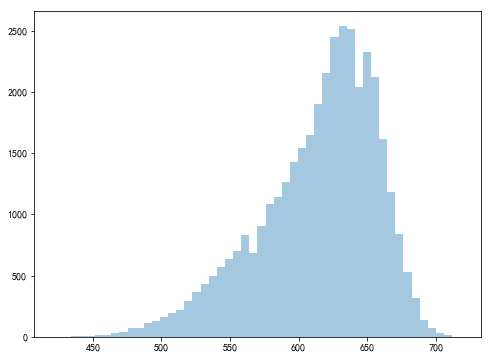

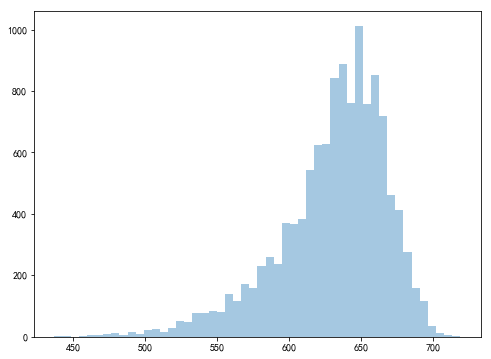

In [37]:
for val in train_df[check_feat].unique():
    plt.figure(figsize=(8, 6))
    sns.distplot(train_df.loc[train_df[check_feat] == val, '信用分'].values, bins=50, kde=False)

### 1.4  顺序性的数值型字段（有大小关系的）和目标变量的相关关系

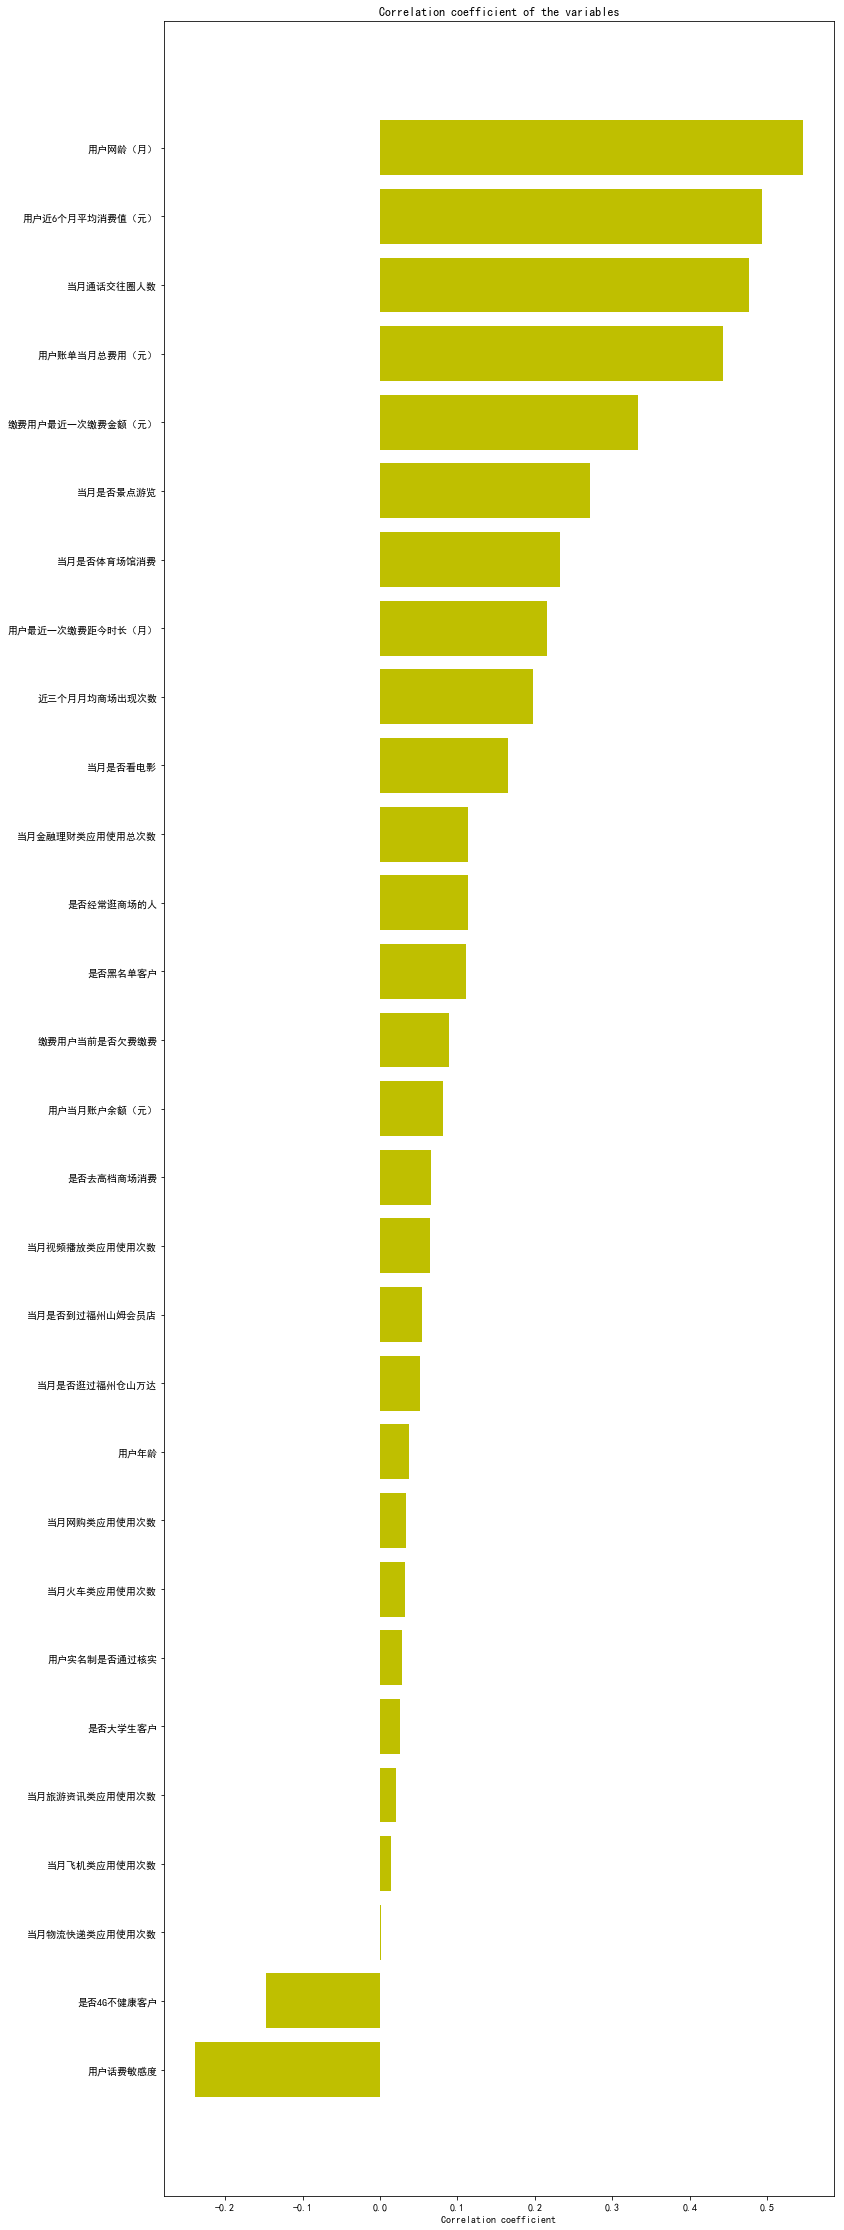

In [41]:
x_cols = [col for col in train_df.columns if col not in ['信用分'] if train_df[col].dtype != 'object']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df['信用分'].values)[0, 1])
corr_df = pd.DataFrame({'cols_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

idx = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(idx, np.array(corr_df['corr_values'].values), color='y')
ax.set_yticks(idx)
ax.set_yticklabels(corr_df['cols_labels'].values, rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coefficient of the variables')

### 1.5 对数据做基本处理，再次观察单变量相关关系

In [43]:
def base_process(data_df):
    transform_value_feats = ['用户年龄', '用户网龄（月）', '当月通话交往圈人数', '近三个月月均商场出现次数',
                            '当月网购类应用使用次数', '当月物流快递类应用使用次数', '当月金融理财类应用使用总次数', 
                             '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数', 
                             '当月旅游资讯类应用使用次数']
    bill_feats = ['缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）','用户账单当月总费用（元）', 
                   '用户当月账户余额（元）']
    log_feats = ['当月网购类应用使用次数', '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数']
    
    # 处理极小或极大的离散点
    for col in transform_value_feats + bill_feats:
        up_limit = np.percentile(train_df[col].values, 99.9) # 99.9%分位数
        low_limit = np.percentile(train_df[col].values, 0.1) # 0.1%分位数
        train_df[col][train_df[col] > up_limit] = up_limit
        train_df[col][train_df[col] < low_limit] = low_limit
    
    # 解决正太分布左偏的情况，取对数
    for col in bill_feats + log_feats:
        train_df[col] = train_df[col].map(lambda x : np.log1p(x))
    
    return train_df

# run
train_df = base_process(train_df)

In [44]:
# 新增一个特征
train_df['交通类APP使用次数'] = train_df['当月飞机类应用使用次数'] + train_df['当月火车类应用使用次数']

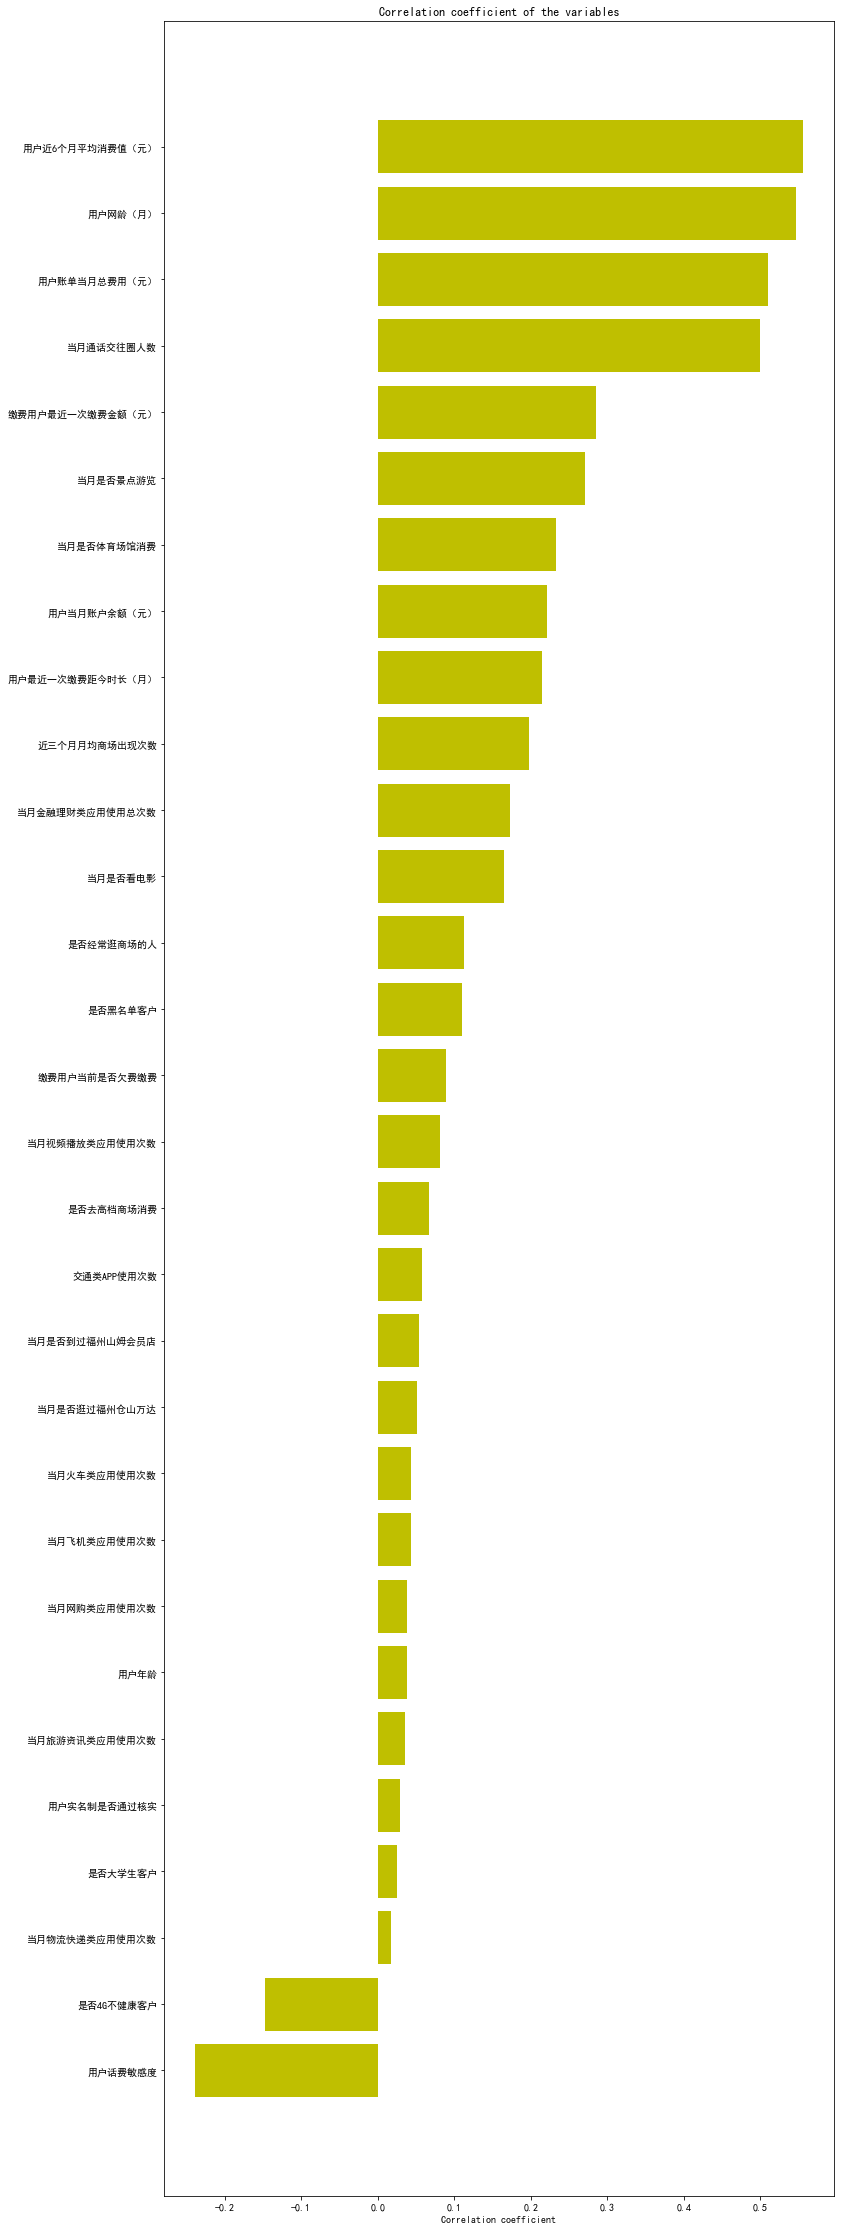

In [45]:
# 比较 base_process 处理后，相关系数的变化情况
x_cols = [col for col in train_df.columns if col not in ['信用分'] if train_df[col].dtype != 'object']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df['信用分'].values)[0, 1])
corr_df = pd.DataFrame({'cols_labels': labels, 'corr_values': values})
corr_df = corr_df.sort_values(by='corr_values')

idx = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots(figsize=(12, 40))
rects = ax.barh(idx, np.array(corr_df['corr_values'].values), color='y')
ax.set_yticks(idx)
ax.set_yticklabels(corr_df['cols_labels'].values, rotation='horizontal')
ax.set_xlabel('Correlation coefficient')
ax.set_title('Correlation coefficient of the variables')

# 还是很明显的，头几个相关性系数是有变化的

### 1.6 所有连续变量之间的两两相关关系

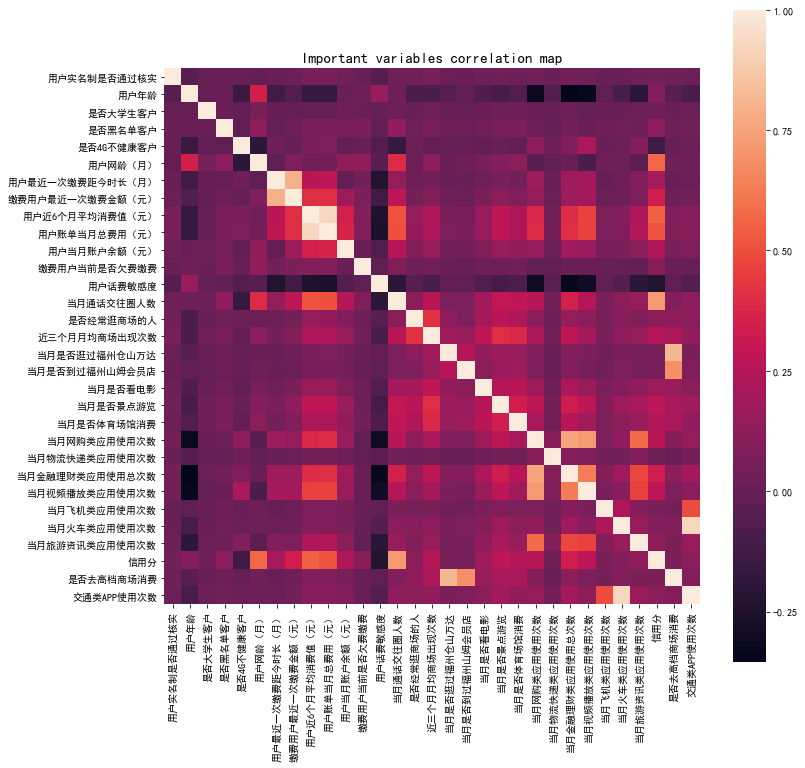

In [49]:
corr_mat = train_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(corr_mat, vmax=1., square=True)
plt.title('Important variables correlation map', fontsize=15)

## #2 Feature Engineering


### 1. feature value processing

In [19]:
# 新创建一个特征：是否去高档商场消费，创建了这个特征后可以用 distplot 在不同取值上看一下，是有一定的区别度的所以这个特征可取。
train_df['是否去高档商场消费'] = train_df['当月是否到过福州山姆会员店'] + train_df['当月是否逛过福州仓山万达']

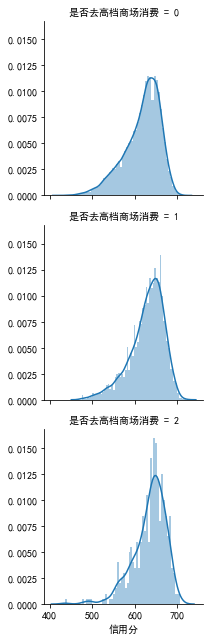

In [25]:
g = sns.FacetGrid(train_df, '是否去高档商场消费')
g = g.map(sns.distplot, '信用分', bins=50, kde=False)

#### 1.1 age
看到有 age 为0和超过100的用户，这一部分的用户很明显信息是不准确的，那么在一定程度上来讲，他们的信用分不会太高。那么把他们处理成平均年龄。

改了反而得分降低了，线上线下都有降低，所以不能这么处理，在查看了 test_df 中也是有类似的情况后，就采取保留措施。

In [7]:
# train_df['age'][train_df['age']<6] = train_df['age'].mean()
# train_df['age'][train_df['age']>100] = train_df['age'].mean()

##### 1.2  '缴费用户最近一次缴费金额（元）'--(top_up_amount)
通过 EDA 知道，这个特征与 score_qcut 强线性相关。观察看到充值数字有整数和小数，可能是充值方式不同，作为一个新特征试一下，

In [8]:
def produce_top_up_amount_feat(data_df):
    data_df['top_up_amount_new'] = 0
    data_df['top_up_amount_new'][(data_df['top_up_amount'] % 10 == 0) & (data_df['top_up_amount'] != 0)] = 1
    onehot_cols.append('top_up_amount_new')
    return data_df

### 2. 数值特征的简单变换 Feature Construction


#### 2.1 ratio feature
###### 2.1.1 top_up_amount / curr_month_balance
'缴费用户最近一次缴费金额（元）'/'用户当月账户余额（元）'--(top_up_amount) / curr_month_balance 充值金额和当前月的比例

这个特征并没有什么提升。

In [9]:
def produce_amount_balance_ratio_feat(data_df):
    data_df['amount_balance_ratio'] = data_df['top_up_amount'] / (data_df['curr_month_balance'] + 1)
    scale_cols.append('amount_balance_ratio')
    return data_df

###### 2.1.2 total_account_fee / curr_month_balance
'用户账单当月总费用（元）'/ '用户当月账户余额（元）' (total_account_fee/curr_month_balance)

有一定提升

In [10]:
def produce_fee_balance_ratio_feat(data_df):
    data_df['fee_balance_ratio'] = data_df['total_account_fee'] / (data_df['curr_month_balance'] + 1)
    scale_cols.append('fee_balance_ratio')
    return data_df

##### 2.1.3 total_account_fee / recent_6month_avg_use
'用户账单当月总费用（元）'/ '用户近6个月平均消费值（元）'（total_account_fee/recent_6month_avg_use）

有较大提升。

In [11]:
# def produce_amount_use_ratio_feat(data_df):
#     data_df['amount_use_ratio'] = data_df['total_account_fee'] / (data_df['recent_6month_avg_use'] + 1)
#     scale_cols.append('amount_use_ratio')
#     return data_df

##### 2.1.4 age / net_age_till_now
'用户年龄'/ '用户网龄（月）'（total_account_fee/recent_6month_avg_use）

In [12]:
def produce_age_net_ratio_feat(data_df):
    data_df['age_net_ratio'] = data_df['age'] * 12 / (data_df['net_age_till_now'] + 1)
#     scale_cols.append('age_net_ratio')
    return data_df

###### 2.1.5 total_account_fee / top_up_amount
'用户账单当月总费用（元）'/ '缴费用户最近一次缴费金额（元）' (total_account_fee/top_up_amount)

线下有较大提升

In [13]:
def produce_fee_top_ratio_feat(data_df):
    data_df['fee_top_ratio'] = data_df['total_account_fee'] * 12 / (data_df['top_up_amount'] + 1)
    scale_cols.append('fee_top_ratio')
    return data_df

###### 2.1.6 recent_6month_avg_use / top_up_amount
 '用户近6个月平均消费值（元）'/ '缴费用户最近一次缴费金额（元）' (recent_6month_avg_use / top_up_amount)

In [14]:
def produce_use_top_ratio_feat(data_df):
    data_df['use_top_ratio'] = data_df['recent_6month_avg_use'] * 12 / (data_df['top_up_amount'] + 1)
    scale_cols.append('use_top_ratio')
    return data_df

###### 2.1.7 recent_6month_avg_use / curr_month_balance
 '用户近6个月平均消费值（元）'/ '用户当月账户余额（元）' (recent_6month_avg_use / curr_month_balance)

In [15]:
def produce_use_balance_ratio_feat(data_df):
    data_df['use_balance_ratio'] = data_df['recent_6month_avg_use'] * 12 / (data_df['curr_month_balance'] + 1)
    scale_cols.append('use_balance_rscale_colsatio')
    return data_df

In [16]:
# combine the ratio features
def produce_ratio_feats(data_df):
    # 2.1.1 '缴费用户最近一次缴费金额（元）'/'用户当月账户余额（元） top_up_amount / curr_month_balance
    data_df = produce_amount_balance_ratio_feat(data_df)
    
    # 2.1.2 '用户账单当月总费用（元）'/ '用户当月账户余额（元）'  total_account_fee / curr_month_balance
    data_df = produce_fee_balance_ratio_feat(data_df)
    
    # 2.1.3 '用户账单当月总费用（元）'/ '用户近6个月平均消费值  top_up_amount / recent_6month_avg_use
#     data_df = produce_amount_use_ratio_feat(data_df)
    
    # 2.1.4 '用户年龄'/ '用户网龄（月）'  age / net_age_till_now
    data_df = produce_age_net_ratio_feat(data_df)
    
    # 2.1.5 total_account_fee / top_up_amount
    data_df = produce_fee_top_ratio_feat(data_df)
    
    # 2.1.6 recent_6month_avg_use / top_up_amount
    data_df = produce_use_top_ratio_feat(data_df)
    
    # 2.1.7 recent_6month_avg_use / curr_month_balance
#     data_df = produce_use_balance_ratio_feat(data_df)
    return data_df

### 3. 类别特征与数值特征的组合

In [17]:
start_time = time.time()

for cat_feat in categorical_cols:
    for num_feat in numerical_cols:

        cat_num_mean = train_df.groupby(cat_feat)[num_feat].mean()
        cat_num_median = train_df.groupby(cat_feat)[num_feat].median()
#         cat_num_mode = train_df.groupby(cat_feat)[num_feat].apply(lambda x: x.mode())
        cat_num_min = train_df.groupby(cat_feat)[num_feat].min()
        cat_num_max = train_df.groupby(cat_feat)[num_feat].max()
        cat_num_std = train_df.groupby(cat_feat)[num_feat].std()
#         cat_num_freq = train_df.groupby(cat_feat)[num_feat].freq()
        cat_num_var = train_df.groupby(cat_feat)[num_feat].var()
    
        train_df[cat_feat+'_'+num_feat+'_'+'mean'] = train_df[cat_feat].map(cat_num_mean)
        train_df[cat_feat+'_'+num_feat+'_'+'median'] = train_df[cat_feat].map(cat_num_median)
#         train_df[cat_feat+'_'+num_feat+'_'+'mode'] = train_df[cat_feat].map(cat_num_mode)
        train_df[cat_feat+'_'+num_feat+'_'+'min'] = train_df[cat_feat].map(cat_num_min)
        train_df[cat_feat+'_'+num_feat+'_'+'max'] = train_df[cat_feat].map(cat_num_max)
        train_df[cat_feat+'_'+num_feat+'_'+'std'] = train_df[cat_feat].map(cat_num_std)
        train_df[cat_feat+'_'+num_feat+'_'+'var'] = train_df[cat_feat].map(cat_num_var)

        test_df[cat_feat+'_'+num_feat+'_'+'mean'] = test_df[cat_feat].map(cat_num_mean)
        test_df[cat_feat+'_'+num_feat+'_'+'median'] = test_df[cat_feat].map(cat_num_median)
#         test_df[cat_feat+'_'+num_feat+'_'+'mode'] = test_df[cat_feat].map(cat_num_mode)
        test_df[cat_feat+'_'+num_feat+'_'+'min'] = test_df[cat_feat].map(cat_num_min)
        test_df[cat_feat+'_'+num_feat+'_'+'max'] = test_df[cat_feat].map(cat_num_max)
        test_df[cat_feat+'_'+num_feat+'_'+'std'] = test_df[cat_feat].map(cat_num_std)
        test_df[cat_feat+'_'+num_feat+'_'+'var'] = test_df[cat_feat].map(cat_num_var)
        
        scale_cols.append(cat_feat+'_'+num_feat+'_'+'mean')
        scale_cols.append(cat_feat+'_'+num_feat+'_'+'median')
        scale_cols.append(cat_feat+'_'+num_feat+'_'+'min')
        scale_cols.append(cat_feat+'_'+num_feat+'_'+'max')
        scale_cols.append(cat_feat+'_'+num_feat+'_'+'std')
        scale_cols.append(cat_feat+'_'+num_feat+'_'+'var')
        
print 'elapsed time: ', time.time() - start_time

elapsed time:  24.9350039959


#### 2.2 add features


In [19]:
# 缴费用户最近一次缴费金额（元） 整数 or not
train_df = produce_top_up_amount_feat(train_df)
test_df = produce_top_up_amount_feat(test_df)

In [20]:
train_df = produce_ratio_feats(train_df)
test_df = produce_ratio_feats(test_df)

### X. 归一化

In [35]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scale_cols = scale_cols + numerical_cols
onehot_cols = onehot_cols + categorical_cols

for col in scale_cols:
    train_df[col] = StandardScaler().fit_transform(np.array(train_df[col]).reshape(-1, 1))
    test_df[col] = StandardScaler().fit_transform(np.array(test_df[col]).reshape(-1, 1))

for col in onehot_cols:
    train_df[col] = StandardScaler().fit_transform(np.array(train_df[col]).reshape(-1, 1))
    test_df[col] = StandardScaler().fit_transform(np.array(test_df[col]).reshape(-1, 1))

## #3 Training

In [40]:
# drop useless features
print train_df.columns, len(train_df.columns)
X = train_df.drop(drop_cols + ['score'], axis=1)
X_submit = test_df.drop(drop_cols, axis=1)

Index([u'uid', u'true_name_flag', u'age', u'uni_student_flag',
       u'blk_list_flag', u'4g_unhealth_flag', u'net_age_till_now',
       u'top_up_month_diff', u'top_up_amount', u'recent_6month_avg_use',
       ...
       u'uni_student_flag_top_up_month_diff_min',
       u'uni_student_flag_top_up_month_diff_max',
       u'uni_student_flag_top_up_month_diff_std',
       u'uni_student_flag_top_up_month_diff_var', u'top_up_amount_new',
       u'amount_balance_ratio', u'fee_balance_ratio', u'age_net_ratio',
       u'fee_top_ratio', u'use_top_ratio'],
      dtype='object', length=1188) 1188


In [50]:
# # Dimension Reduction
# from sklearn.decomposition import PCA
# pca = PCA(n_components=600)
# pca.fit(X)
# X = pca.fit_transform(X)
# pca.fit(X_submit)
# X_submit = pca.fit_transform(X_submit)
# print X.shape, X_submit.shape

(50000, 600) (50000, 600)


In [42]:
# k-cv
N_FOLDS = 5
y = train_df['score']
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
kf = kfold.split(X, y)

In [52]:
# # LightGBM: GBDT
# params = {
#     'learning_rate': 0.01,
#     'boosting_type': 'gbdt',
#     'objective': 'regression_l1',
#     'metric': 'mae',
#     'feature_fraction': 0.6,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 2,
#     'num_leaves': 31,
#     'verbose': -1,
#     'max_depth': 5,
#     'lambda_l2': 5, 'lambda_l1': 0
# }

# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.show()
    
# # 0--------------------------------------1



# # process the k-cv
# cv_pred = np.zeros(test_df.shape[0])
# valid_best_l2_all = 0

# feature_importance_df = pd.DataFrame()
# count = 0
# for i, (train_idx, test_idx) in enumerate(kf):
#     print('fold: ',i, ' training')
# #     X_train, X_test, y_train, y_test = X.iloc[train_idx, :], X.iloc[test_idx, :], y.iloc[train_idx], y.iloc[test_idx]
#     X_train, X_test, y_train, y_test = X[train_idx, :], X[test_idx, :], y[train_idx], y[test_idx]
#     data_train = lgb.Dataset(X_train, y_train)
#     data_test = lgb.Dataset(X_test, y_test)
#     lgb_model = lgb.train(params, data_train, num_boost_round=10000, valid_sets=data_test, 
#                           verbose_eval=-1, early_stopping_rounds=50)
#     cv_pred += lgb_model.predict(X_submit, num_iteration=lgb_model.best_iteration)
#     valid_best_l2_all += lgb_model.best_score['valid_0']['l1']
    
# #     fold_importance_df = pd.DataFrame()
# #     fold_importance_df["feature"] = list(X_train.columns)
# #     fold_importance_df["importance"] = lgb_model.feature_importance(importance_type='gain', iteration=lgb_model.best_iteration)
# #     fold_importance_df["fold"] = count + 1
# #     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     count += 1
    
# cv_pred /= N_FOLDS
# valid_best_l2_all /= N_FOLDS
# print('cv score for valid is: ', 1/(1+valid_best_l2_all))

# # show the importance of features
# # display_importances(feature_importance_df)

('fold: ', 0, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2773]	valid_0's l1: 16.4886
('fold: ', 1, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3603]	valid_0's l1: 16.5658
('fold: ', 2, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3150]	valid_0's l1: 16.3583
('fold: ', 3, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2770]	valid_0's l1: 16.2151
('fold: ', 4, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3190]	valid_0's l1: 16.6352
('cv score for valid is: ', 0.057298056743075802)


In [43]:
# Logistical Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

# process the k-cv
cv_pred = np.zeros(test_df.shape[0])
valid_best_l2_all = 0

feature_importance_df = pd.DataFrame()
count = 0
for i, (train_idx, test_idx) in enumerate(kf):
    print('fold: ',i, ' training')
    X_train, X_test, y_train, y_test = X.iloc[train_idx, :], X.iloc[test_idx, :], y.iloc[train_idx], y.iloc[test_idx]
#     X_train, X_test, y_train, y_test = X[train_idx, :], X[test_idx, :], y[train_idx], y[test_idx]
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
    valid_best_l2_all += mean_absolute_error(clf.predict(X_test), y_test)
    cv_pred += clf.predict(X_submit)

cv_pred /= N_FOLDS
print('cv score for valid is: ', 1/(1+valid_best_l2_all))

('fold: ', 0, ' training')
('fold: ', 1, ' training')
('fold: ', 2, ' training')
('fold: ', 3, ' training')
('fold: ', 4, ' training')
('cv score for valid is: ', 0.0098168283910136898)


## Submit

In [44]:
submit_df = test_df[['uid']]
submit_df['score'] = cv_pred
submit_df.columns = ['id', 'score']

# int
submit_df['score'] = submit_df['score'].apply(lambda x: int(np.round(x)))
submit_df.to_csv('./submission/baseline_2019-03-04T12:51:35_0.0098168283910136898.csv', index=False)

In [77]:
submit_df.head(10)

,id,score
0,7171737d49b143d1b38883a39e4a5730,121
1,3af0a449d5424488912e8fb2bf4b9faa,107
2,eb2cf02e0d5c4d1294dd73e776dbb441,134
3,9c0f780ecb254670a11aa9e3f10777c5,135
4,d794eed46c1e44f785a575f18b3023a5,131
5,18f6a7d824a1421b9da3e5f10854c3df,123
6,e7b63888a36f499a88811c0936bb12df,128
7,f995ef4d96fc426191a104421b0f5b20,115
8,11a3ce45ce234f7db4e91e5f152dc8b8,135
9,86ebeac087284c87bbcb1281d95ef9eb,116


In [46]:
# data_dummies = pd.get_dummies(train_df[numerical_cols])
# data_dummies.head(20)